In [27]:
import sys

In [28]:
import pathlib
import xarray as xr

In [29]:
from init import *

In [30]:
import syfop

In [31]:
from syfop.util import *
from syfop.node import *
from syfop.network import *

In [6]:
import os
os.environ['GRB_LICENSE_FILE'] = '/home/pregner/gurobi.lic'

# this does not work in jupyter notebook, needs to be set in kernel spec!
# see /home/pregner/micromamba/envs/syfop-global-costs/share/jupyter/kernels/python3/kernel.json
# os.environ['LD_LIBRARY_PATH'] = '/opt/gurobi1001/linux64/lib'

## Parameters

In [15]:
from src.model_parameters import pv_cost
from src.model_parameters import wind_cost
from src.model_parameters import methanol_demand
from src.model_parameters import storage_params
from src.model_parameters import co2_cost
from src.model_parameters import co2_convert_factor
from src.model_parameters import electrolizer_cost
from src.model_parameters import electrolizer_convert_factor
from src.model_parameters import methanol_synthesis_cost
from src.model_parameters import methanol_synthesis_convert_factor
from src.model_parameters import methanol_synthesis_input_proportions


## Renewable time series

In [16]:
# XXX whats the unit here?!

In [17]:
#%%timeit -r1 -n1
wind_raw = xr.open_mfdataset([INTERIM_DIR / 'wind' / f'wind_2012-{month:02d}.nc' for month in MONTHS])
pv_raw = xr.open_mfdataset([INTERIM_DIR / 'wind' / f'wind_2012-{month:02d}.nc' for month in MONTHS])

In [18]:
x_idx = 132
y_idx = 233

In [19]:
#%%timeit -r1 -n1

# oh no! we picked a leap year by chance... let's just throw away the last day
wind_input_flow = wind_raw.isel(x=x_idx, y=y_idx, time=slice(None, 8760))['specific generation'].load()
pv_input_flow = pv_raw.isel(x=x_idx, y=y_idx, time=slice(None, 8760))['specific generation'].load()

In [20]:
pv_raw.sizes['x'] * pv_raw.sizes['y'] / 3600 / 8

36.0

## Model

In [21]:
from src.methanol_network import create_methanol_network

In [36]:
#%%timeit -n1 -r1

network  = create_methanol_network(
    pv_input_flow=pv_input_flow,
    pv_cost=pv_cost,
    wind_input_flow=wind_input_flow,
    wind_cost=wind_cost,
    methanol_demand=methanol_demand,
    storage_params=storage_params,
    co2_cost=co2_cost,
    co2_convert_factor=co2_convert_factor,
    electrolizer_cost=electrolizer_cost,
    electrolizer_convert_factor=electrolizer_convert_factor,
    methanol_synthesis_cost=methanol_synthesis_cost,
    methanol_synthesis_convert_factor=methanol_synthesis_convert_factor,
    methanol_synthesis_input_proportions=methanol_synthesis_input_proportions,
)

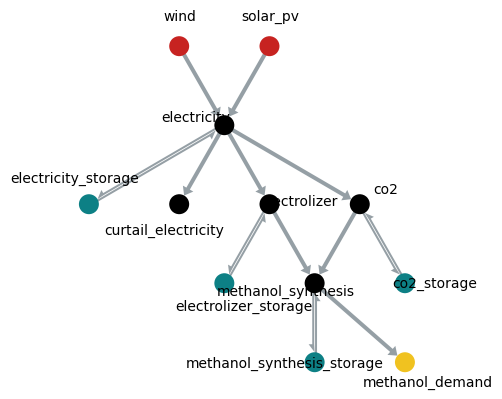

In [37]:
network.draw()

In [38]:
#%%timeit -n1 -r1

# network.optimize('highs')
#network.optimize('highs')

In [39]:
network.model.solution.to_netcdf('/tmp/highs.nc')

PermissionError: [Errno 13] Permission denied: b'/tmp/highs.nc'

In [40]:
#%%timeit -n1 -r1

# network.optimize('highs')
network.optimize('gurobi')

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen Threadripper 2950X 16-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 254040 rows, 183969 columns and 698714 nonzeros
Model fingerprint: 0x5571d046
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [3e+01, 2e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+03, 1e+03]
Presolve removed 97616 rows and 80097 columns
Presolve time: 0.76s
Presolved: 156424 rows, 103872 columns, 451384 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.06s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 5.087e+05
 Factor NZ  : 2.358e+06 (roughly 120 MB of memory)
 Factor Ops : 3.949e+07 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          

In [43]:
[x for x in network.model.solution.variables if x.startswith('size')]

['size_solar_pv',
 'size_wind',
 'size_storage_electricity',
 'size_storage_electrolizer',
 'size_electrolizer',
 'size_storage_co2',
 'size_co2',
 'size_storage_methanol_synthesis',
 'size_methanol_synthesis']

In [ ]:
network.model.solution.to_netcdf('/tmp/gurobi.nc')

In [ ]:
gurobi = network.model.solution

In [33]:
highs = xr.open_dataset('/tmp/highs.nc')

In [32]:
(highs - gurobi).max()

NameError: name 'highs' is not defined

##  Parallelize

In [16]:
OUTPUT_VARS = ['size_wind', 'size_solar_pv', 'size_storage_co2']

In [17]:
import io
from contextlib import redirect_stdout


In [18]:
#def optimize_bla(wind_input_flow, pv_input_flow):
def optimize_bla(param):
    print("start opt")
    wind_input_flow = param.wind_input_flow
    pv_input_flow = param.pv_input_flow
    network  = create_methanol_network(
        pv_input_flow=pv_input_flow,
        pv_cost=pv_cost,
        wind_input_flow=wind_input_flow,
        wind_cost=wind_cost,
        methanol_demand=methanol_demand,
        storage_params=storage_params,
        co2_cost=co2_cost,
        co2_convert_factor=co2_convert_factor,
        electrolizer_cost=electrolizer_cost,
        electrolizer_convert_factor=electrolizer_convert_factor,
        methanol_synthesis_cost=methanol_synthesis_cost,
        methanol_synthesis_convert_factor=methanol_synthesis_convert_factor,
        methanol_synthesis_input_proportions=methanol_synthesis_input_proportions,
    )
    
    with io.StringIO() as buf, redirect_stdout(buf):
        network.optimize('gurobi')
        output = buf.getvalue()

    return network.model.solution[OUTPUT_VARS].expand_dims(x=pv_input_flow.x, y=pv_input_flow.y)

In [19]:
wind_input_flow = wind_raw.isel(x=slice(x_idx, x_idx+5), y=slice(y_idx,y_idx+3), time=slice(None, 8760))['specific generation'].load()
pv_input_flow = pv_raw.isel(x=slice(x_idx, x_idx+5), y=slice(y_idx,y_idx+3), time=slice(None, 8760))['specific generation'].load()

In [20]:
param = xr.Dataset(
    {'wind_input_flow': wind_input_flow,
     'pv_input_flow': pv_input_flow
    })
param = param.chunk(time=None, x=1, y=1)

In [21]:
param

<xarray.Dataset>
Dimensions:          (y: 3, x: 5, time: 8760)
Coordinates:
  * y                (y) float64 -31.75 -31.5 -31.25
  * x                (x) float64 -147.0 -146.8 -146.5 -146.2 -146.0
  * time             (time) datetime64[ns] 2012-01-01 ... 2012-12-30T23:00:00
    lon              (y, x) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat              (y, x) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
Data variables:
    wind_input_flow  (time, y, x) float64 dask.array<chunksize=(8760, 1, 1), meta=np.ndarray>
    pv_input_flow    (time, y, x) float64 dask.array<chunksize=(8760, 1, 1), meta=np.ndarray>

In [22]:
optimize_bla(param.isel(x=[0], y=[0]))

start opt


<xarray.Dataset>
Dimensions:           (x: 1, y: 1)
Coordinates:
  * x                 (x) float64 -147.0
  * y                 (y) float64 -31.75
Data variables:
    size_wind         (x, y) float64 0.0
    size_solar_pv     (x, y) float64 0.578
    size_storage_co2  (x, y) float64 0.0

In [23]:
template = xr.Dataset({name: xr.zeros_like(pv_input_flow.isel(time=0).drop_vars(('time', 'lon', 'lat'))) for name in OUTPUT_VARS},
                      coords=pv_input_flow.coords).drop_vars(('time', 'lon', 'lat'))
template = template.chunk(x=1, y=1)

In [24]:
template

<xarray.Dataset>
Dimensions:           (y: 3, x: 5)
Coordinates:
  * y                 (y) float64 -31.75 -31.5 -31.25
  * x                 (x) float64 -147.0 -146.8 -146.5 -146.2 -146.0
Data variables:
    size_wind         (y, x) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    size_solar_pv     (y, x) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    size_storage_co2  (y, x) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [46]:
from multiprocessing import Pool
import time

In [85]:
for _, px in param.groupby('x'):
    for _, py in px.groupby('y'):
        ...

In [93]:
py.expand_dims(x=1, y=1).drop_vars(('lon', 'lat'))

<xarray.Dataset>
Dimensions:          (y: 1, x: 1, time: 8760)
Coordinates:
  * y                (y) float64 -31.25
  * x                (x) float64 -146.0
  * time             (time) datetime64[ns] 2012-01-01 ... 2012-12-30T23:00:00
Data variables:
    wind_input_flow  (x, y, time) float64 dask.array<chunksize=(1, 1, 8760), meta=np.ndarray>
    pv_input_flow    (x, y, time) float64 dask.array<chunksize=(1, 1, 8760), meta=np.ndarray>

In [90]:
param_

<xarray.Dataset>
Dimensions:          (y: 1, x: 1, time: 8760)
Coordinates:
  * y                (y) float64 -31.75
  * x                (x) float64 -146.5
  * time             (time) datetime64[ns] 2012-01-01 ... 2012-12-30T23:00:00
    lon              (y, x) float64 -146.5
    lat              (y, x) float64 -31.75
Data variables:
    wind_input_flow  (time, y, x) float64 0.4037 0.3256 0.3223 ... 0.1791 0.1775
    pv_input_flow    (time, y, x) float64 0.4037 0.3256 0.3223 ... 0.1791 0.1775

In [87]:
optimize_bla(py)

start opt


ValueError: IndexVariable objects must be 1-dimensional

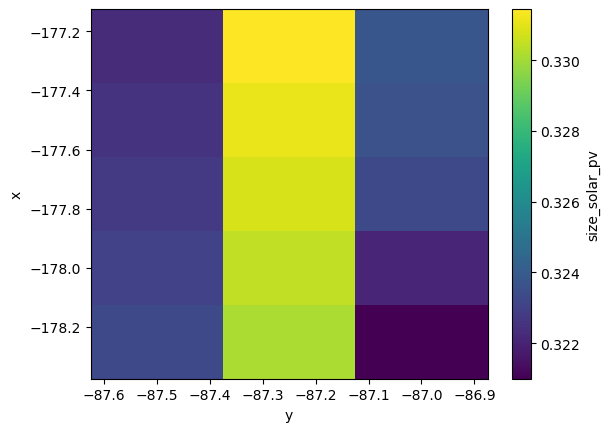

In [95]:
xr.open_dataset(INTERIM_DIR / 'out_chunk.nc').size_solar_pv.plot()

In [52]:
param_sequence = (param.isel(x=[i],y=[0]).compute() for i in range(3))

In [53]:
res = []

In [54]:
t0 = time.time()
for i, param_ in enumerate(param_sequence):
    print(i)
    res.append(optimize_bla(param_))

print("runtime: ", time.time() - t0)

0
start opt
1
start opt
2
start opt
runtime:  22.90180206298828


In [63]:
%%timeit
xr.concat(res, dim='y')

6.62 ms ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:

    optimize_bla,
    param,
    # TODO network needs to be passed as kwarg?
    template=template,
).compute()

ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file


ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file


ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
ValueError: I/O operation on closed file
ValueErr

ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
Exception ignored in: ValueError: I/O operation on closed file
'

Solving time:  89.66692352294922


In [92]:
xr.map_blocks(
    optimize_bla,
    param,
    # TODO network needs to be passed as kwarg?
    template=template,
).compute()

ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file


ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file


ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
ValueError: I/O operation on closed file
ValueErr

ValueError: I/O operation on closed file

Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
Exception ignored in: ValueError: I/O operation on closed file
'

Solving time:  89.66692352294922


In [ ]:
15*6

ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
    m.optimize()
ValueError: I/O operation on closed file
Exception ignored in: 'gurobipy.logcallbackstub'
Traceback (most recent call last):
  File "/home/pregner/micromamba/envs/syfop-global-costs/lib/python3.9/site-packages/linopy/solvers.py", line 557, in run_gurobi
    m.optimize()
ValueError: I/O operation on closed file
    m.optimize()
ValueError: I/O operation on closed file
ValueError: I/O operation on closed file
ValueError: I/O operati

In [66]:
xr.apply_ufunc(
    optimize_bla,
    wind_input_flow,
    pv_input_flow,
    input_core_dims=[['time'], ['time']],
)

AttributeError: 'numpy.ndarray' object has no attribute 'time'

In [44]:
pv_input_flow

<xarray.DataArray 'specific generation' (time: 8760)>
array([0.45867569, 0.37555879, 0.39808107, ..., 0.22903145, 0.19637886,
       0.18788047])
Coordinates:
    y        float64 -31.75
    x        float64 -147.0
  * time     (time) datetime64[ns] 2012-01-01 ... 2012-12-30T23:00:00
    lon      float64 -147.0
    lat      float64 -31.75
Attributes:
    units:    MW

In [59]:
optimize_bla().assign_coords(x=pv_input_flow.x)

<xarray.Dataset>
Dimensions:           ()
Coordinates:
    y                 float64 -31.75
    lon               float64 -147.0
    lat               float64 -31.75
    x                 float64 -147.0
Data variables:
    size_wind         float64 0.0
    size_solar_pv     float64 0.578
    size_storage_co2  float64 0.0